<a href="https://colab.research.google.com/github/amura/xray-machinelearning/blob/resnet50/resnet50_x-rays_1b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Jun  7 20:49:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Import required dependencies
import pandas as pd
from io import BytesIO
import numpy as np
import os
import shutil
import pprint
import json
from PIL import Image
from PIL.ImageStat import Stat
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import pathlib
import cv2

In [3]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
!pip list | grep tensorflow

tensorflow                    2.5.0              
tensorflow-datasets           4.0.1              
tensorflow-estimator          2.5.0              
tensorflow-gcs-config         2.5.0              
tensorflow-hub                0.12.0             
tensorflow-metadata           1.0.0              
tensorflow-probability        0.12.1             


In [5]:
# setup drive
from google.colab import drive
drive.mount('/content/gdrive') 

Mounted at /content/gdrive


In [6]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/ML"

In [7]:
#changing the working directory
%cd /content/gdrive/MyDrive/ML

/content/gdrive/MyDrive/ML


In [8]:

#!ls /root/.keras/datasets/ -la
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

 99% 740M/745M [00:14<00:00, 50.4MB/s]
100% 745M/745M [00:14<00:00, 55.1MB/s]


## Data setup

In [9]:
if not os.path.exists('/content/x-ray'): 
    print("Creating x-ray folder") 
    os.makedirs('/content/x-ray')

# mv the data to temp folder
!unzip /content/gdrive/MyDrive/ML/covid19-radiography-database.zip -d /content/x-ray  > /dev/null 2>&1

Creating x-ray folder


In [10]:
# delete original file from drive
!rm /content/gdrive/MyDrive/ML/covid19-radiography-database.zip

In [11]:
import glob
#!ls /root/.keras/datasets -laR
covid_dir = os.path.join('/content','x-ray','COVID-19_Radiography_Dataset','COVID')
non_covid_dir =os.path.join('/content','x-ray','COVID-19_Radiography_Dataset','Normal')
covidCount = len(  os.listdir(covid_dir) )
nonCovidCount = len( os.listdir(non_covid_dir))
print(f'{covidCount} covid images')
print(f'{nonCovidCount} non covid images')

3616 covid images
10192 non covid images


## Image preview

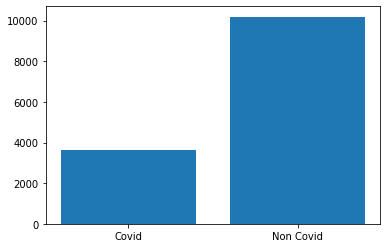

In [12]:
# Showing distribution of images
x = np.array([0,1])
plt.bar(x, height=[covidCount, nonCovidCount] )
plt.xticks(x, ['Covid', 'Non Covid'])
plt.show()

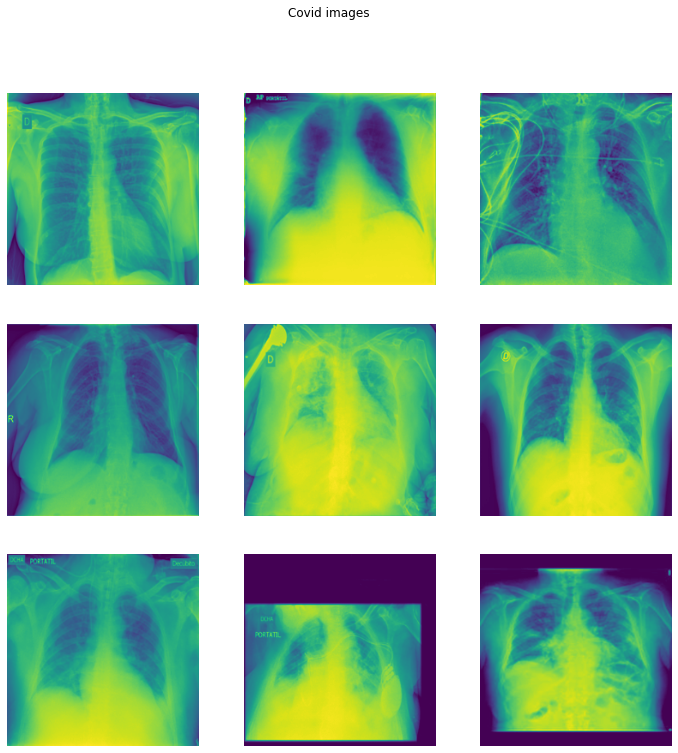

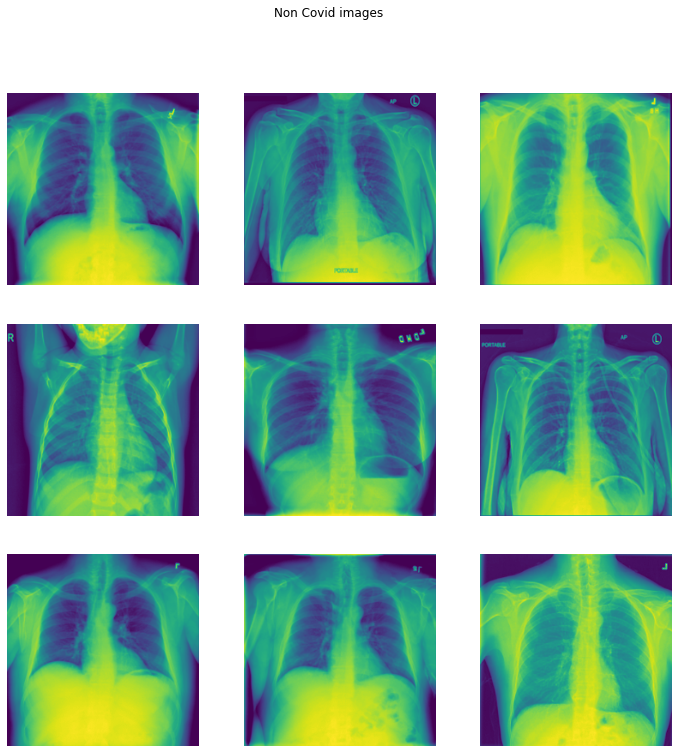

In [13]:
import random
batch_size = 32
img_height = 224
img_width = 224
size = (224,224)

nrows = 3
ncols = 3

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

preview_covid = os.listdir(covid_dir)
preview_non_covid = os.listdir(non_covid_dir)

randIndex = random.randint(10, covidCount)
next_covid = [os.path.join(covid_dir, fname) 
              for fname in preview_covid[randIndex-9:randIndex]                 
             ]
randIndex = random.randint(10, nonCovidCount)
next_non_covid = [os.path.join(non_covid_dir, fname) 
              for fname in preview_non_covid[randIndex-9:randIndex]   
             ]
fig.suptitle('Covid images')
for i, img_path in enumerate(next_covid):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  img = cv2.resize(img, size)
  plt.imshow(img)  
plt.show()     

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

fig.suptitle('Non Covid images')
for i, img_path in enumerate(next_non_covid):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path,0)
  img = cv2.resize(img, size)
  plt.imshow(img)  


plt.show()



### Image stats

[0]: Min/Max [(0, 243)] Mean [142.31118220154136], Variance [1711.3642902333652], StdDev [41.368638970038226]
[1]: Min/Max [(0, 255)] Mean [175.3239225512019], Variance [4615.478714184849], StdDev [67.93731459356374]
[2]: Min/Max [(27, 217)] Mean [130.97294213711257], Variance [924.6681082653408], StdDev [30.40835589546631]
[3]: Min/Max [(0, 235)] Mean [103.71347076654624], Variance [2081.946245200343], StdDev [45.62834913954638]
[4]: Min/Max [(4, 209)] Mean [162.1217659757721], Variance [903.3369476357967], StdDev [30.055564337336882]
[5]: Min/Max [(0, 239)] Mean [138.8104048053154], Variance [4109.868842199195], StdDev [64.10825876748794]

[0]: Min/Max [(0, 246)] Mean [126.68113332065637], Variance [4729.484424867416], StdDev [68.77124707948386]
[1]: Min/Max [(0, 235)] Mean [112.74687084037092], Variance [3083.016696537148], StdDev [55.52491959955591]
[2]: Min/Max [(0, 248)] Mean [177.26260332658472], Variance [2430.3208226049146], StdDev [49.29828417505943]
[3]: Min/Max [(0, 250)] M

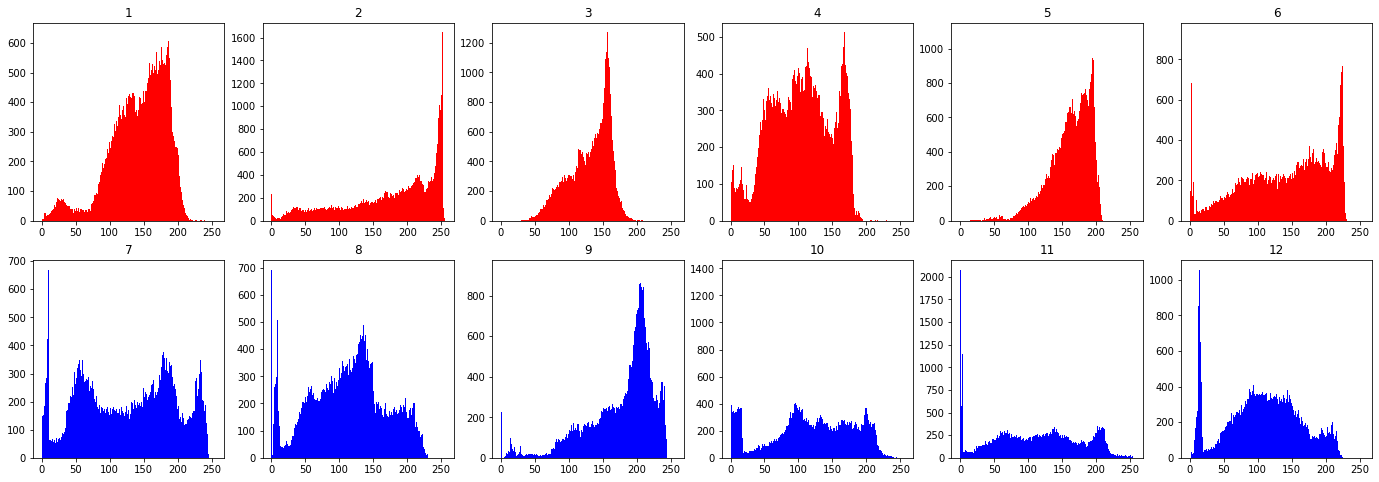

In [14]:



nrows = 2
ncols = 6

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
plt.title('Image distribution')
for i, img_path in enumerate(next_covid):
  if i > 5:
    break
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.set_label('Covid')
  sp.set_title(i + 1)
  img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
  img = cv2.resize(img, size)
  hist = cv2.calcHist([img],[0],None,[256],[0,256])
  plt.hist(img.ravel(),256,[0,256], color="red", label="Covid")
  
  img = Image.open(img_path)
  st = Stat(img)
  print(f'[{i}]: Min/Max {st.extrema} Mean {st.mean}, Variance {st.var}, StdDev {st.stddev}')  
  
print('')  

for i, img_path in enumerate(next_non_covid):
  if i > 5:
    break
  sp = plt.subplot(nrows, ncols, i + 7)
  sp.set_label('Covid')  
  sp.set_title(i + 7)
  img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
  img = cv2.resize(img, size)
  hist = cv2.calcHist([img],[0],None,[256],[0,256])
  plt.hist(img.ravel(),256,[0,256], color="blue", label="Non Covid")
  img = Image.open(img_path)
  st = Stat(img)
  print(f'[{i}]: Min/Max {st.extrema} Mean {st.mean}, Variance {st.var}, StdDev {st.stddev}')  


plt.show()

## Dicom image processing

In [15]:
# install utility for converting to dicom
!pip install simpleitk  > /dev/null 2>&1

In [16]:
def generateDicom(folderEnumerator, pathToTarget):
    for i, img_path in enumerate(folderEnumerator):
        img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, size)
        img = sitk.GetImageFromArray(img)
        sitk.WriteImage(img, os.path.join(pathToTarget + str(i) + '.dcm'))

In [17]:
import SimpleITK as sitk
import shutil

if not os.path.exists('/content/dicom/covid'): 
    print("Creating covid dicom folder") 
    os.makedirs('/content/dicom/covid')
else:
  shutil.rmtree('/content/dicom/covid')  
  print("Creating covid dicom folder") 
  os.makedirs('/content/dicom/covid')

if not os.path.exists('/content/dicom/non_covid'): 
    print("Creating non covid dicom folder") 
    os.makedirs('/content/dicom/non_covid')
else:
  shutil.rmtree('/content/dicom/non_covid')  
  print("Creating non covid dicom folder") 
  os.makedirs('/content/dicom/non_covid')

next_covid = [os.path.join(covid_dir, fname) 
              for fname in preview_covid                 
             ]
next_non_covid = [os.path.join(non_covid_dir, fname) 
              for fname in preview_non_covid   
             ]


Creating covid dicom folder
Creating non covid dicom folder


In [18]:

#Convert to dicom
generateDicom(next_covid, '/content/dicom/covid/c_')


#Convert to dicom
generateDicom(next_non_covid, '/content/dicom/non_covid/c_')

## Generate output csv files

In [19]:
# import to dataframes

next_covid_dicom = [os.path.join('/content/dicom/covid', fname) 
              for fname in os.listdir('/content/dicom/covid')                 
             ]
next_non_covid_dicom = [os.path.join('/content/dicom/non_covid', fname) 
              for fname in os.listdir('/content/dicom/non_covid')   
             ]


covidData = { 'paths': np.array(next_covid_dicom), 'label': 'covid' }
nonCovidData = { 'paths': np.array(next_non_covid_dicom), 'label': 'non-covid'}

frame = pd.DataFrame(covidData)
frame = frame.append(pd.DataFrame(nonCovidData), ignore_index=True)

frame


,paths,label
0,/content/dicom/covid/c_2784.dcm,covid
1,/content/dicom/covid/c_2440.dcm,covid
2,/content/dicom/covid/c_2183.dcm,covid
3,/content/dicom/covid/c_2919.dcm,covid
4,/content/dicom/covid/c_1171.dcm,covid
...,...,...
13803,/content/dicom/non_covid/c_6520.dcm,non-covid
13804,/content/dicom/non_covid/c_8566.dcm,non-covid
13805,/content/dicom/non_covid/c_738.dcm,non-covid
13806,/content/dicom/non_covid/c_6529.dcm,non-covid


In [20]:
# output to csv
frame.to_csv('/content/x-ray-scans.csv')